In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.stats.anova import anova_lm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import math
import datetime
from glob import glob
import multiprocessing as mp
import time
import pickle
import os

## Cleaning Data

In [2]:
dataFolder = './original_data/'
dataFiles = [
    'bitmex_candles_2019_06.csv',
    'bitmex_candles_2019_07.csv',
    'bitmex_candles_2019_08.csv',
    'bitmex_candles_2019_09.csv',
    'bitmex_candles_2019_10.csv',
    'bitmex_candles_2019_11.csv',
    'bitmex_candles_2019_12.csv'
]

In [3]:
filenames = glob(dataFolder+'bitmex_candles_2019_*.csv')
dataframes = [pd.read_csv(f) for f in filenames]

In [4]:
df = pd.concat(dataframes, ignore_index=True)

In [5]:
df.head()

,Unnamed: 0,avg_volume,buy_100,buy_1000,buy_10000,buy_100000,buy_200000,buy_50,buy_500,buy_count,...,sell_1000,sell_10000,sell_100000,sell_200000,sell_50,sell_500,sell_count,sell_volume,timestamp,volume
0,0.0,2603.073124,114,74.0,30.0,2.0,NaN,121,89,156,...,381.0,90.0,8.0,3.0,1036,594.0,2456,5706321,2019-09-01 00:00:00,6799227
1,1.0,2754.204380,262,96.0,21.0,1.0,NaN,305,130,380,...,15.0,5.0,0.0,0.0,19,18.0,31,148099,2019-09-01 00:01:00,1131978
2,2.0,1833.722581,88,34.0,4.0,0.0,NaN,102,48,136,...,4.0,0.0,0.0,0.0,10,7.0,19,8865,2019-09-01 00:02:00,284227
3,3.0,2640.428571,76,33.0,6.0,0.0,NaN,102,44,178,...,41.0,18.0,0.0,0.0,102,45.0,228,695860,2019-09-01 00:03:00,1072014
4,4.0,2202.902240,231,94.0,24.0,0.0,NaN,287,124,477,...,5.0,0.0,0.0,0.0,8,5.0,14,19542,2019-09-01 00:04:00,1081625


In [6]:
df.timestamp = pd.to_datetime(df.timestamp)
df.set_index('timestamp',inplace=True)
df.sort_index(inplace=True)

In [7]:
del df['Unnamed: 0']

In [8]:
df.head()

,avg_volume,buy_100,buy_1000,buy_10000,buy_100000,buy_200000,buy_50,buy_500,buy_count,buy_volume,...,sell_100,sell_1000,sell_10000,sell_100000,sell_200000,sell_50,sell_500,sell_count,sell_volume,volume
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-01 00:00:00,4061.297872,142,95.0,19.0,4.0,NaN,160,113,201,1490030,...,374.0,160.0,24.0,1.0,NaN,398,278.0,504,1373185,2863215
2019-06-01 00:01:00,2111.574359,388,181.0,33.0,1.0,NaN,464,252,712,1479285,...,182.0,81.0,11.0,0.0,NaN,198,152.0,263,579500,2058785
2019-06-01 00:02:00,3571.903039,347,186.0,22.0,0.0,NaN,382,232,571,1224395,...,86.0,67.0,21.0,3.0,1.0,91,77.0,120,1243790,2468185
2019-06-01 00:03:00,2161.450116,87,49.0,3.0,0.0,NaN,108,65,172,263639,...,153.0,67.0,16.0,1.0,0.0,186,86.0,259,667946,931585
2019-06-01 00:04:00,2798.259649,28,15.0,3.0,0.0,NaN,32,23,48,170871,...,126.0,59.0,10.0,1.0,0.0,157,74.0,237,626633,797504


In [9]:
# makes sure all rows are present before doing any analysis
def allRowsPresent(cur_df):
    idx_ref = pd.DatetimeIndex(start=cur_df.index[0], end=cur_df.index[-1], freq='min')
    if len(idx_ref[~idx_ref.isin(cur_df.index)]) == 0:
        return True
    else:
        return False

In [10]:
allRowsPresent(df)

True

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 308160 entries, 2019-06-01 00:00:00 to 2019-12-31 23:59:00
Data columns (total 27 columns):
avg_volume     308159 non-null float64
buy_100        308160 non-null int64
buy_1000       308156 non-null float64
buy_10000      308105 non-null float64
buy_100000     306765 non-null float64
buy_200000     302220 non-null float64
buy_50         308160 non-null int64
buy_500        308160 non-null int64
buy_count      308160 non-null int64
buy_volume     308160 non-null int64
close          308159 non-null float64
high           308159 non-null float64
index          43200 non-null float64
low            308159 non-null float64
max_buy        308095 non-null float64
max_sell       308097 non-null float64
open           308159 non-null float64
sell_100       308159 non-null float64
sell_1000      308154 non-null float64
sell_10000     308114 non-null float64
sell_100000    306758 non-null float64
sell_200000    302448 non-null float64
sell_50 

In [12]:
del df['index']

In [13]:
df.loc[df.open.isna()]

,avg_volume,buy_100,buy_1000,buy_10000,buy_100000,buy_200000,buy_50,buy_500,buy_count,buy_volume,...,sell_100,sell_1000,sell_10000,sell_100000,sell_200000,sell_50,sell_500,sell_count,sell_volume,volume
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-28 12:00:00,NaN,0,0.0,0.0,0.0,0.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0


In [14]:
df.loc[:,['open','close','high','low']] = df.loc[:,['open','close','high','low']].fillna(method='ffill')

In [15]:
df.loc[df.open.isna()]

,avg_volume,buy_100,buy_1000,buy_10000,buy_100000,buy_200000,buy_50,buy_500,buy_count,buy_volume,...,sell_100,sell_1000,sell_10000,sell_100000,sell_200000,sell_50,sell_500,sell_count,sell_volume,volume
timestamp,,,,,,,,,,,,,,,,,,,,,


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 308160 entries, 2019-06-01 00:00:00 to 2019-12-31 23:59:00
Data columns (total 26 columns):
avg_volume     308159 non-null float64
buy_100        308160 non-null int64
buy_1000       308156 non-null float64
buy_10000      308105 non-null float64
buy_100000     306765 non-null float64
buy_200000     302220 non-null float64
buy_50         308160 non-null int64
buy_500        308160 non-null int64
buy_count      308160 non-null int64
buy_volume     308160 non-null int64
close          308160 non-null float64
high           308160 non-null float64
low            308160 non-null float64
max_buy        308095 non-null float64
max_sell       308097 non-null float64
open           308160 non-null float64
sell_100       308159 non-null float64
sell_1000      308154 non-null float64
sell_10000     308114 non-null float64
sell_100000    306758 non-null float64
sell_200000    302448 non-null float64
sell_50        308160 non-null int64
sell_500 

In [17]:
df.loc[:,['avg_volume','buy_50','buy_100','buy_500','buy_1000','buy_10000','buy_100000','buy_200000'
          ,'sell_50','sell_100','sell_500','sell_1000','sell_10000','sell_100000','sell_200000']] = df.loc[:,['avg_volume','buy_50','buy_100','buy_500','buy_1000','buy_10000','buy_100000','buy_200000','sell_50','sell_100','sell_500','sell_1000','sell_10000','sell_100000','sell_200000']].fillna(value=0)


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 308160 entries, 2019-06-01 00:00:00 to 2019-12-31 23:59:00
Data columns (total 26 columns):
avg_volume     308160 non-null float64
buy_100        308160 non-null int64
buy_1000       308160 non-null float64
buy_10000      308160 non-null float64
buy_100000     308160 non-null float64
buy_200000     308160 non-null float64
buy_50         308160 non-null int64
buy_500        308160 non-null int64
buy_count      308160 non-null int64
buy_volume     308160 non-null int64
close          308160 non-null float64
high           308160 non-null float64
low            308160 non-null float64
max_buy        308095 non-null float64
max_sell       308097 non-null float64
open           308160 non-null float64
sell_100       308160 non-null float64
sell_1000      308160 non-null float64
sell_10000     308160 non-null float64
sell_100000    308160 non-null float64
sell_200000    308160 non-null float64
sell_50        308160 non-null int64
sell_500 

In [19]:
df.loc[(df.max_buy.isna()) | (df.max_sell.isna()),['avg_volume','buy_50','buy_100','buy_500','buy_1000','buy_10000','buy_100000','buy_200000'
                                                  ,'sell_50','sell_100','sell_500','sell_1000','sell_10000','sell_100000','sell_200000','max_buy','max_sell']].head()

,avg_volume,buy_50,buy_100,buy_500,buy_1000,buy_10000,buy_100000,buy_200000,sell_50,sell_100,sell_500,sell_1000,sell_10000,sell_100000,sell_200000,max_buy,max_sell
timestamp,,,,,,,,,,,,,,,,,
2019-06-01 20:58:00,571.542636,69,52,23,12.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,NaN
2019-06-02 05:47:00,3451.300000,130,111,78,54.0,17.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,84860.0,NaN
2019-06-06 03:05:00,1785.152000,81,67,45,36.0,5.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,35000.0,NaN
2019-06-09 02:49:00,1935.154930,147,121,74,48.0,8.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,60000.0,NaN
2019-06-11 03:56:00,2399.241935,0,0,0,0.0,0.0,0.0,0.0,50,38.0,29.0,23.0,3.0,0.0,0.0,NaN,37863.0


In [20]:
df.loc[:,['max_buy','max_sell']] = df.loc[:,['max_buy','max_sell']].fillna(value=0)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 308160 entries, 2019-06-01 00:00:00 to 2019-12-31 23:59:00
Data columns (total 26 columns):
avg_volume     308160 non-null float64
buy_100        308160 non-null int64
buy_1000       308160 non-null float64
buy_10000      308160 non-null float64
buy_100000     308160 non-null float64
buy_200000     308160 non-null float64
buy_50         308160 non-null int64
buy_500        308160 non-null int64
buy_count      308160 non-null int64
buy_volume     308160 non-null int64
close          308160 non-null float64
high           308160 non-null float64
low            308160 non-null float64
max_buy        308160 non-null float64
max_sell       308160 non-null float64
open           308160 non-null float64
sell_100       308160 non-null float64
sell_1000      308160 non-null float64
sell_10000     308160 non-null float64
sell_100000    308160 non-null float64
sell_200000    308160 non-null float64
sell_50        308160 non-null int64
sell_500 

## Generate Target Future Values

In [22]:
def asyncFunction(x, minutesAhead):
    x['target'] = 0
    x['target'] = x['target'].astype(np.int64)
    x['return'] = 0
    x['return'] = x['return'].astype(np.float64)
    
    for j, row in x.iterrows():
        try:
            if x.loc[j+datetime.timedelta(minutes=minutesAhead), 'close'] <= x.loc[j, 'close']:
                x.at[j, 'target'] = -1
            else:
                x.at[j, 'target'] = 1
        except KeyError as e:
            pass
    
    x['return'] = abs(x['close'] - x['close'].shift(-minutesAhead)) / x['close']
        
    return dict({minutesAhead: pd.concat([x['target'], x['return']], axis=1)})

In [23]:
pickled_file_path = './pickled_files/targetValues.pickle'
if not os.path.exists(pickled_file_path):
    y_future = dict()

    start = time.time()
    pool = mp.Pool(processes=mp.cpu_count())
    results = [pool.apply_async(asyncFunction, args=(df.copy(), minutesAhead,)) for minutesAhead in range(1,30)]
    optimized_returns = [y_future.update(p.get()) for p in results]

    print('-- time to run: {:2f} seconds --'.format(time.time() - start))
    
    with open('./pickled_files/targetValues.pickle', 'wb') as handle:
        pickle.dump(y_future, handle)
else:
    y_future = pickle.load(open(pickled_file_path,'rb'))

28 seconds to run 1, 57 seconds to run 4, 100 seconds to run 8
should take ~450 seconds (7.5 minutes) to run 30 --
56 seconds to run 4 with returns before more efficient

In [24]:
y_future[29].head()

,target,return
timestamp,,
2019-06-01 00:00:00,-1,0.003453
2019-06-01 00:01:00,-1,0.004324
2019-06-01 00:02:00,-1,0.004028
2019-06-01 00:03:00,-1,0.003620
2019-06-01 00:04:00,-1,0.002454


In [25]:
for i in range(1, len(y_future)+1):
    y_future[i]['x'] = np.random.random(len(y_future[i]))+i

In [26]:
trial = y_future[1].reset_index().copy()

In [27]:
trial['index'] = trial.index

In [28]:
trial.head()

,timestamp,target,return,x,index
0,2019-06-01 00:00:00,1,0.001522,1.734448,0
1,2019-06-01 00:01:00,1,0.000993,1.894560,1
2,2019-06-01 00:02:00,-1,0.000350,1.870249,2
3,2019-06-01 00:03:00,-1,0.000701,1.153905,3
4,2019-06-01 00:04:00,-1,0.000409,1.941929,4


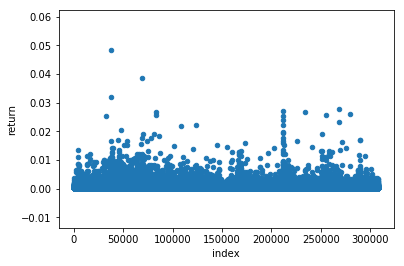

In [29]:
trial.loc[trial.target == 1].plot(x='index',y='return',kind='scatter')

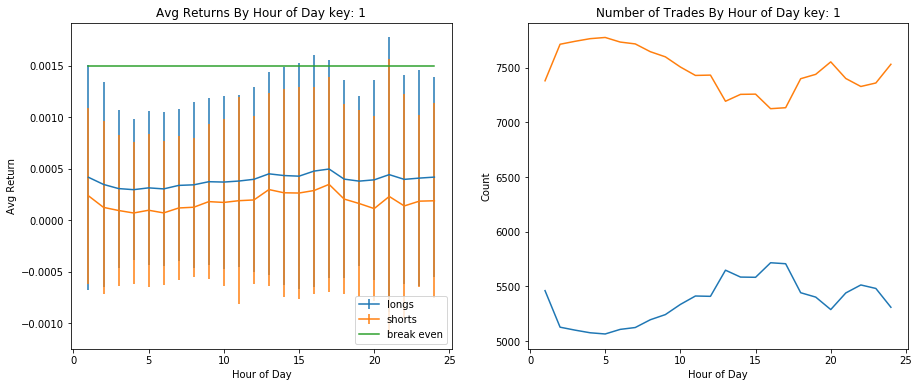

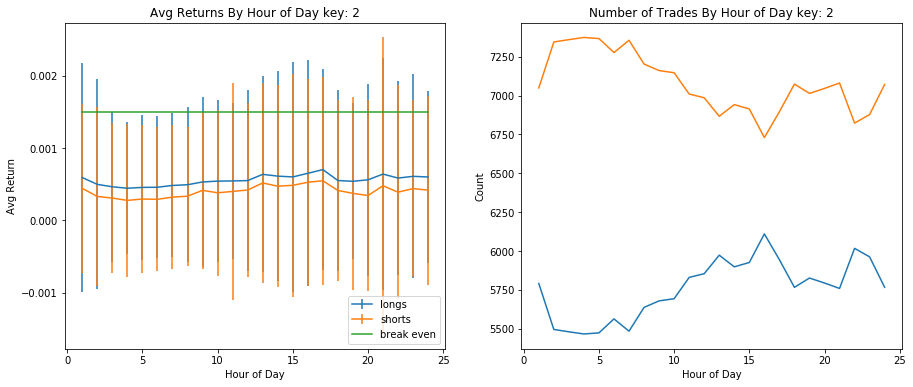

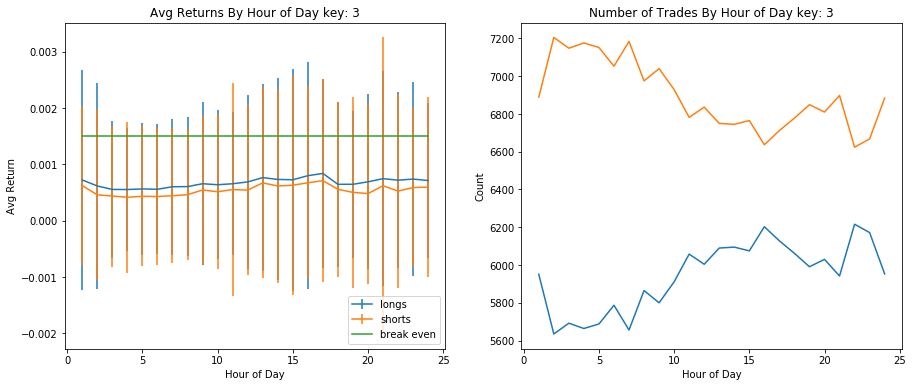

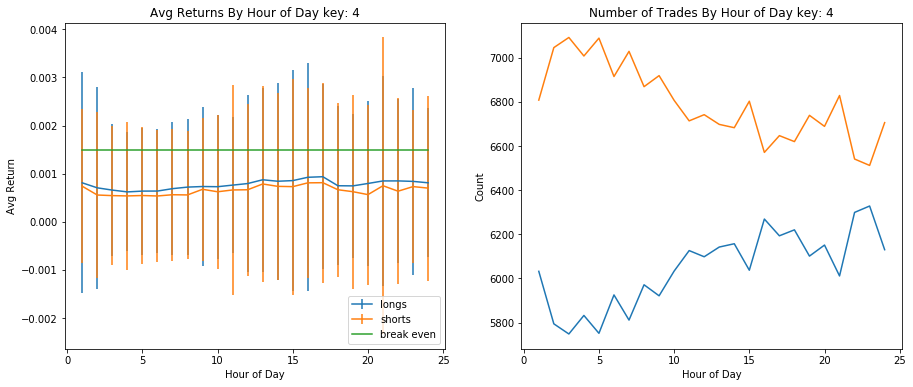

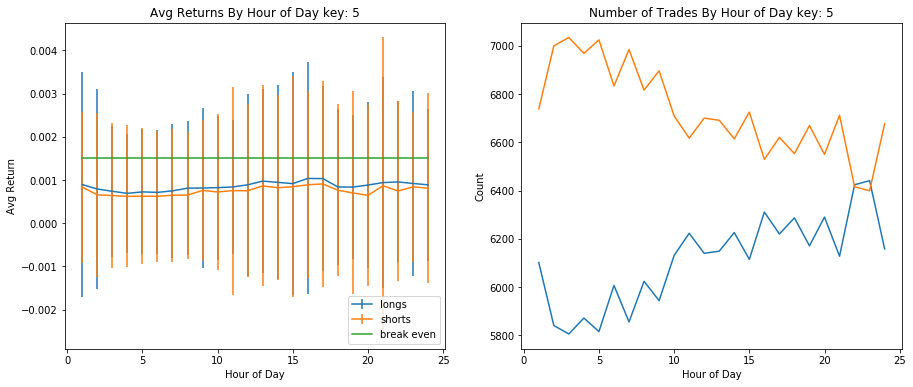

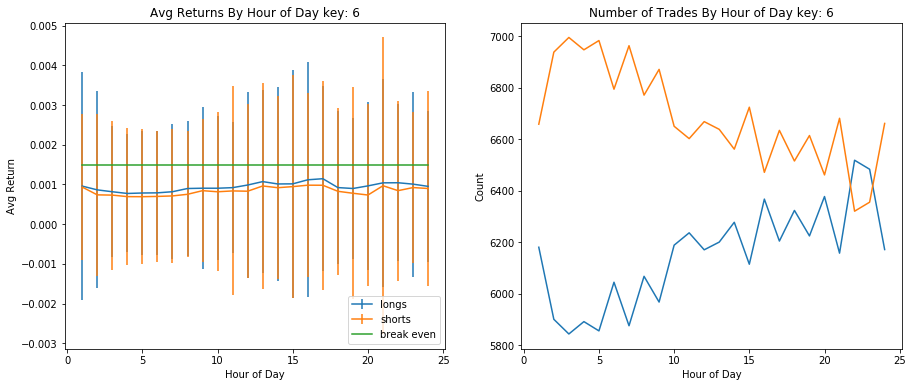

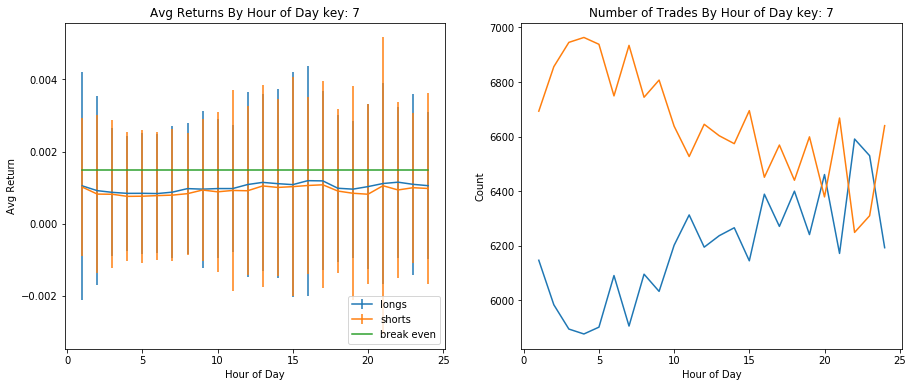

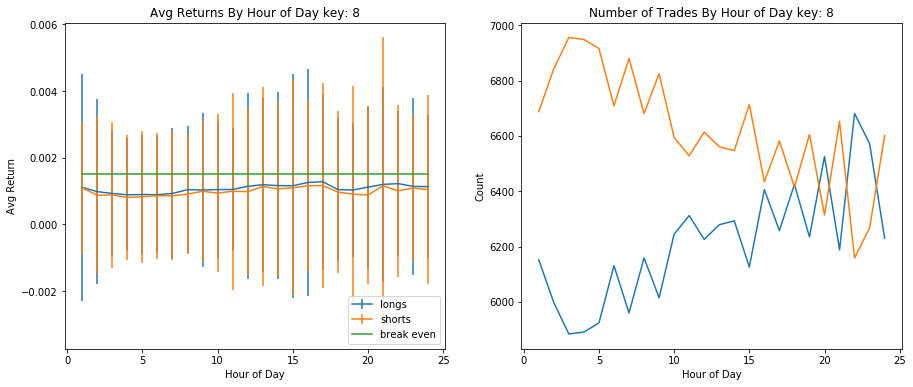

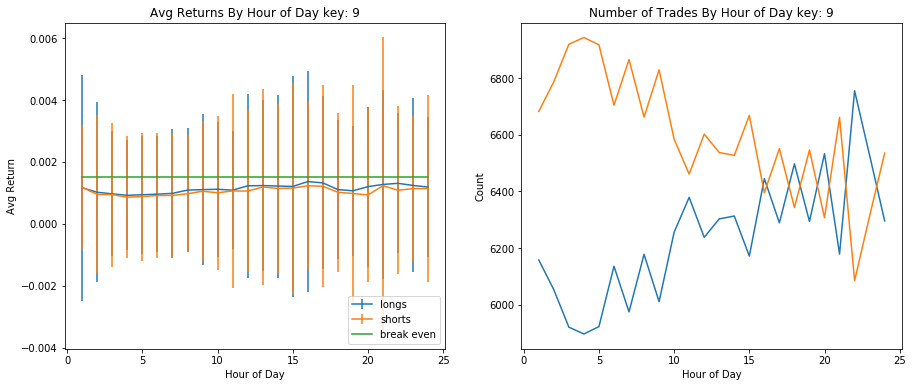

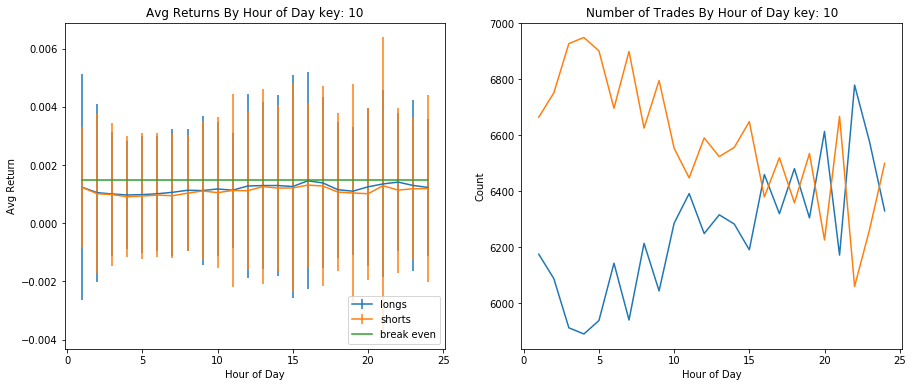

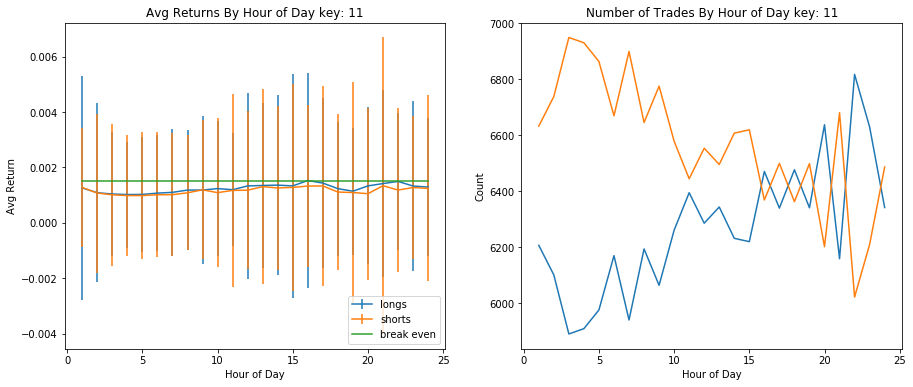

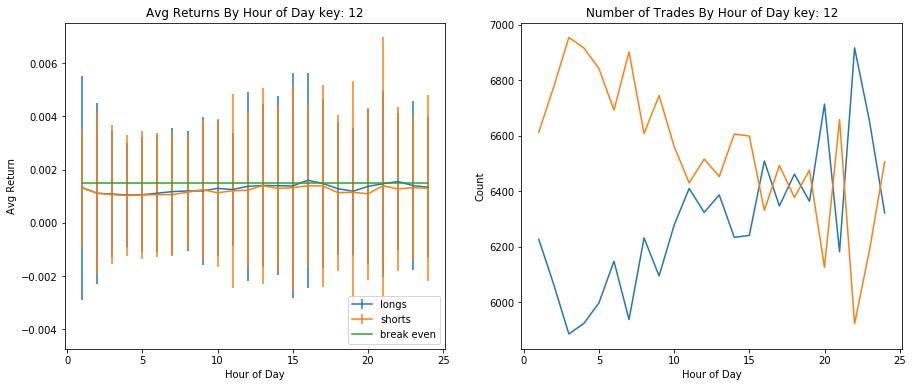

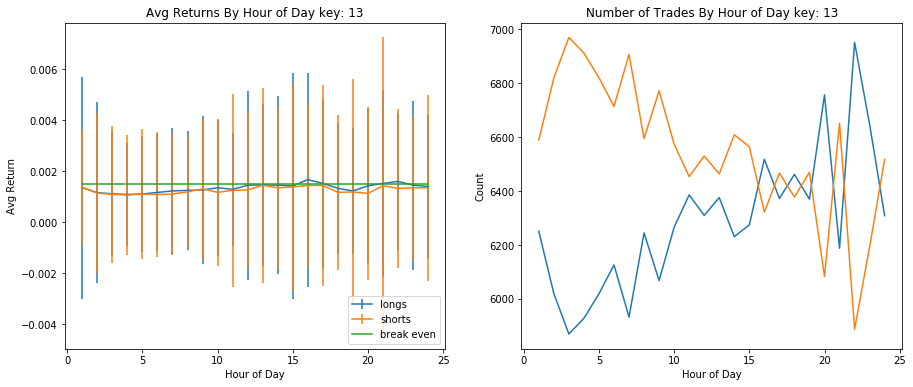

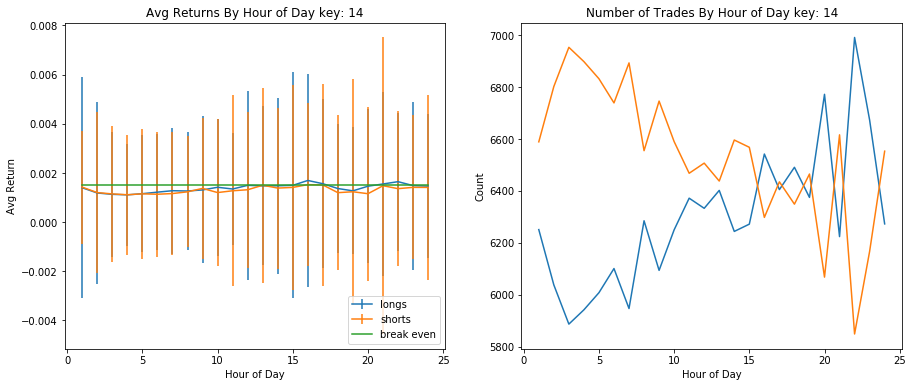

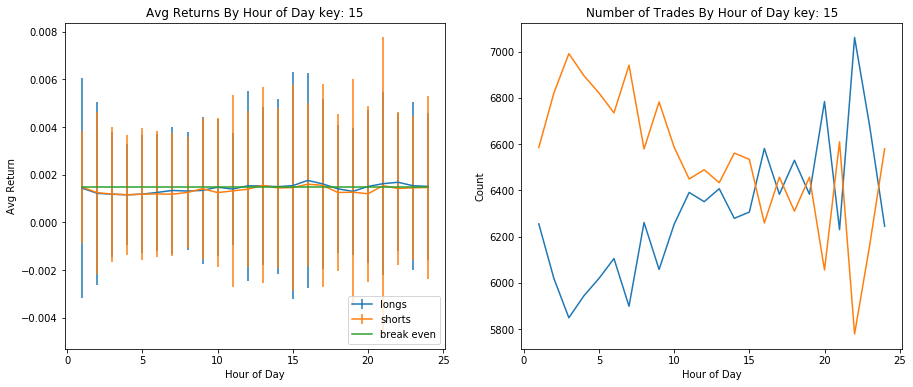

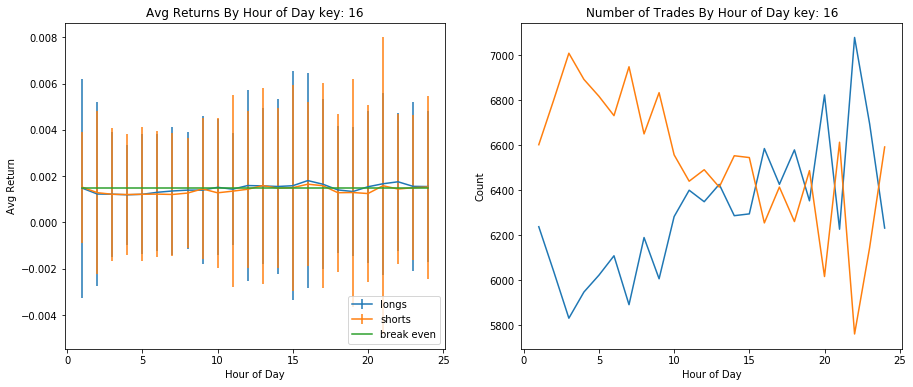

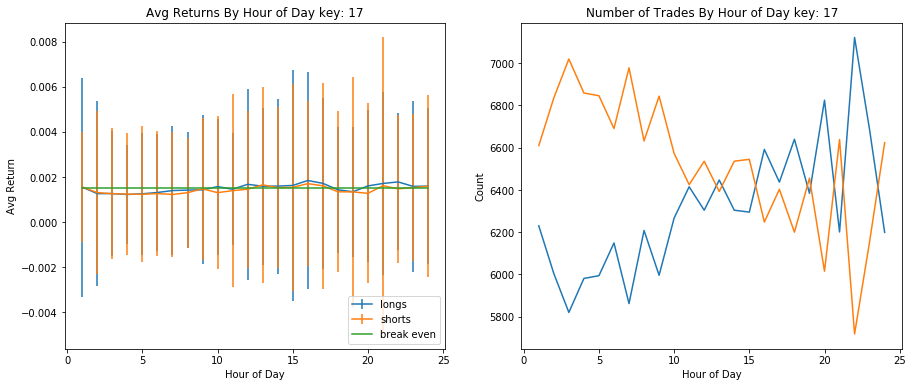

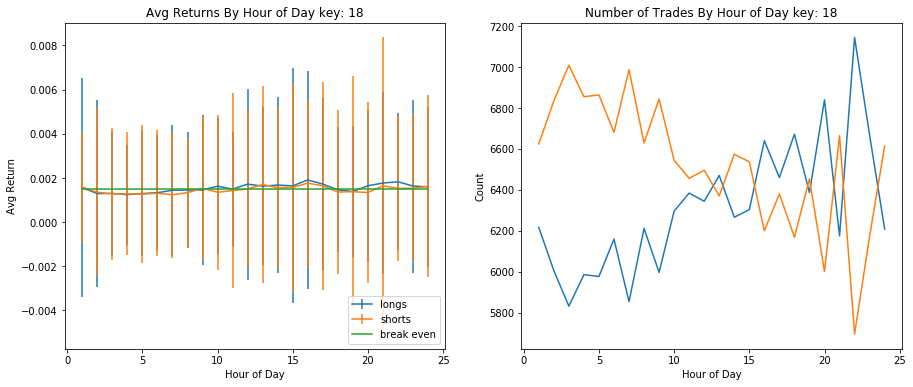

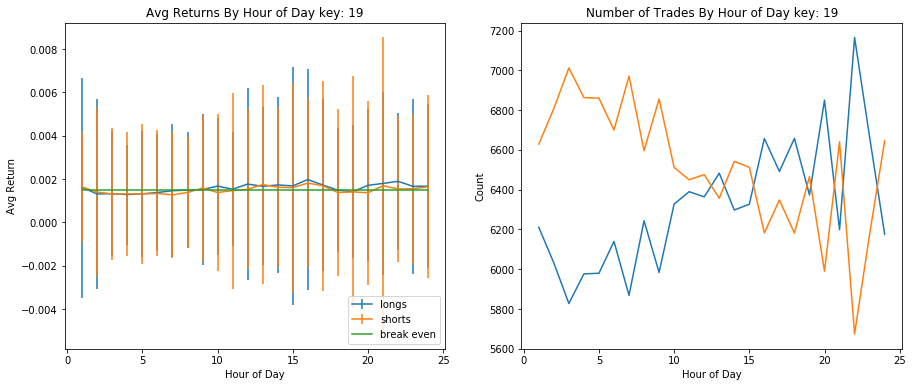

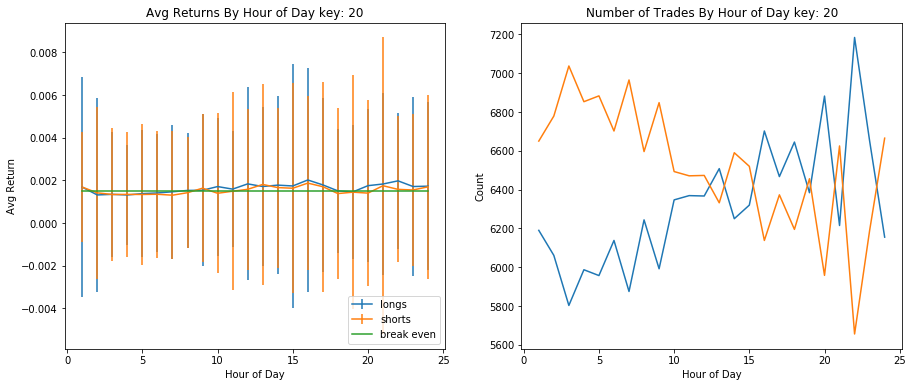

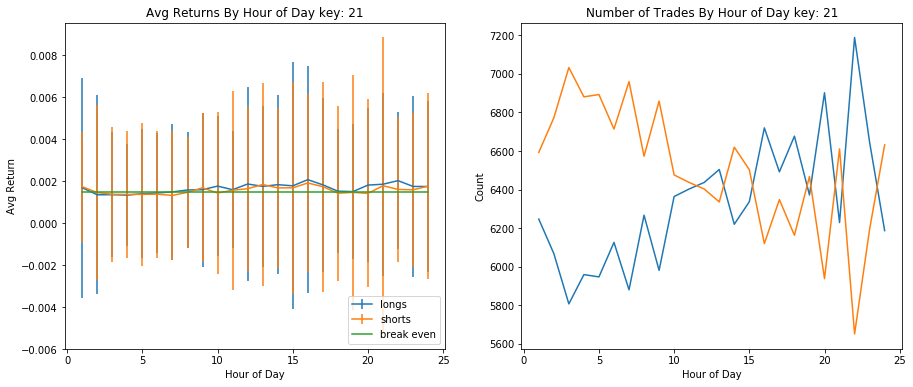

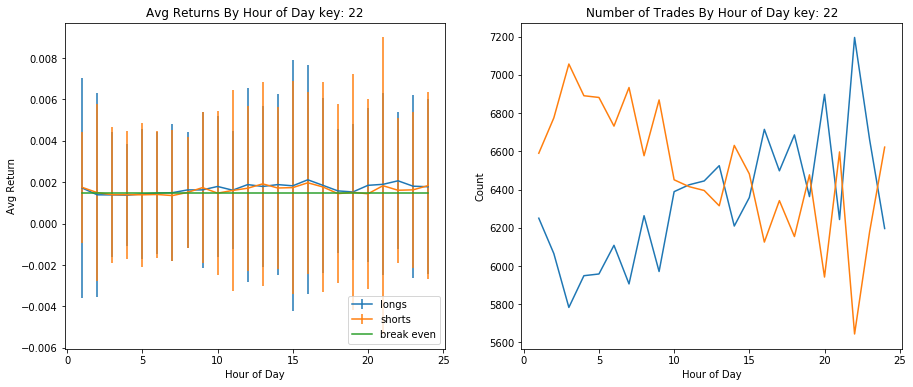

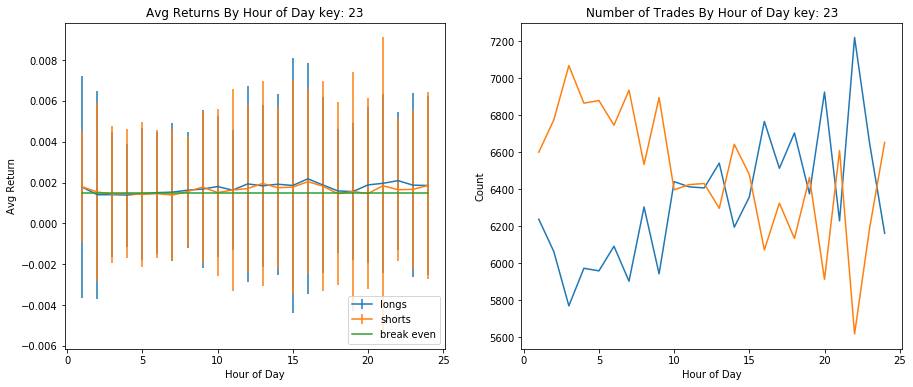

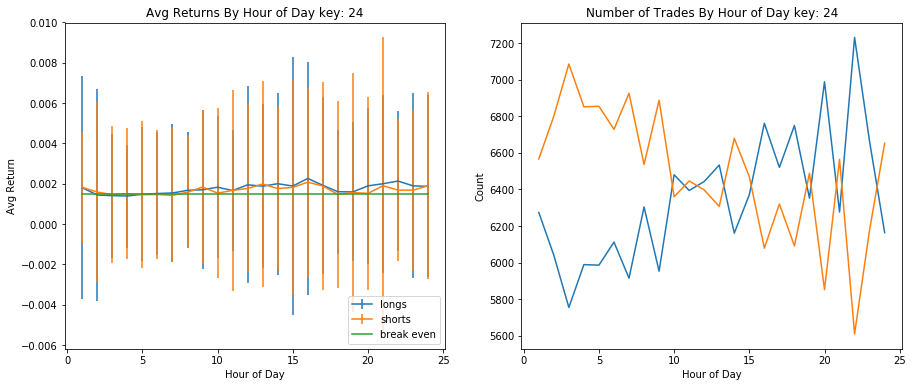

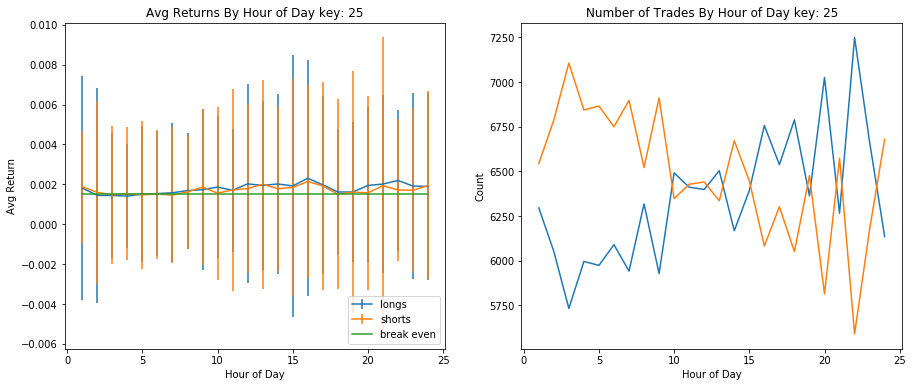

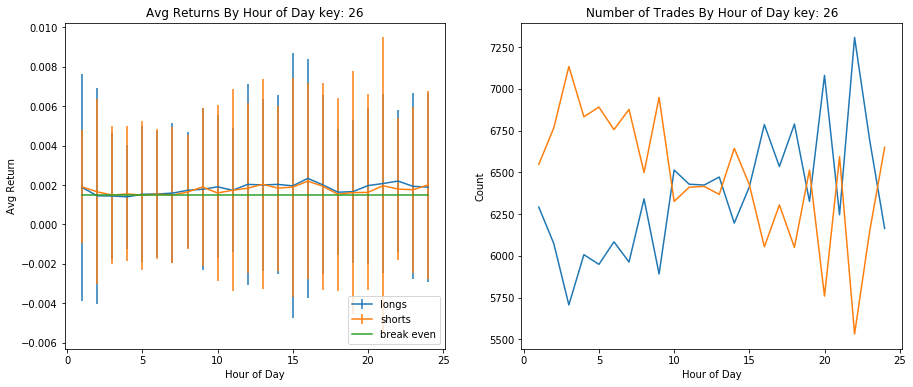

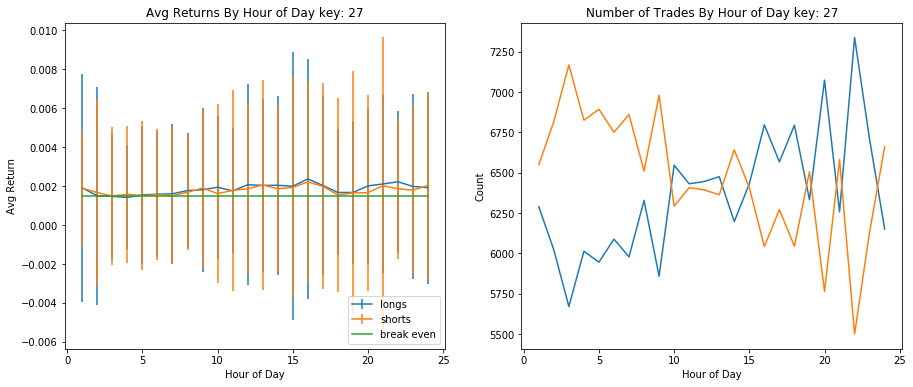

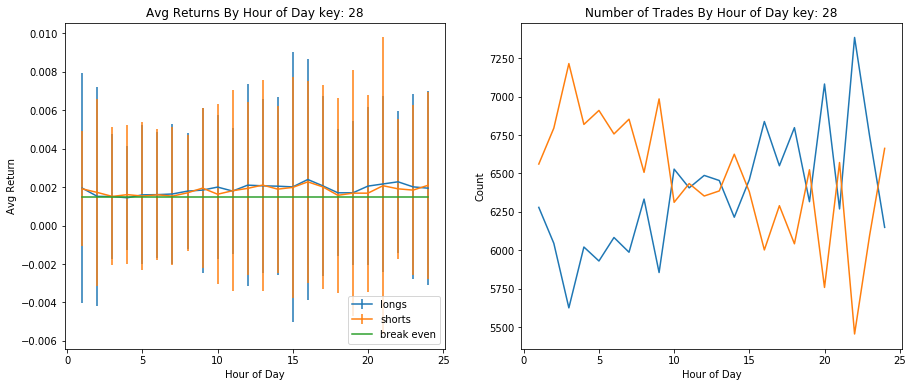

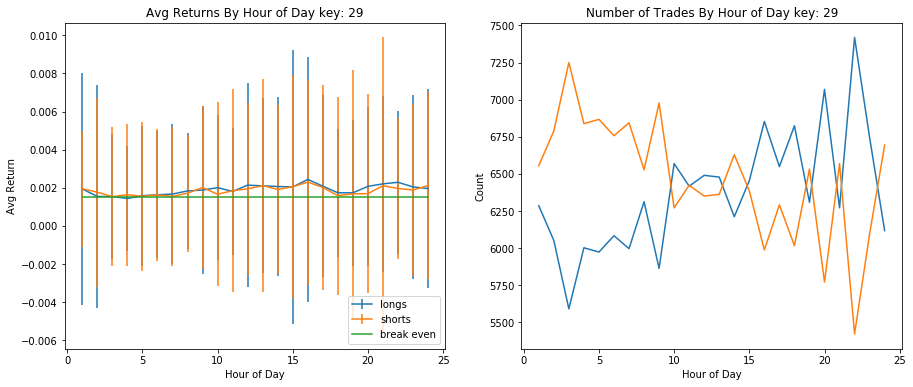

In [30]:
for key in y_future.keys():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    cur = y_future[key].reset_index().copy()

    ax1.errorbar([x for x in range(1,25)], cur.loc[cur.target == 1].groupby(cur.loc[cur.target == 1].timestamp.dt.hour)['return'].median(), yerr=cur.loc[cur.target == 1].groupby(cur.loc[cur.target == 1].timestamp.dt.hour)['return'].std(), label='longs')
    ax1.errorbar([x for x in range(1,25)], cur.loc[cur.target == -1].groupby(cur.loc[cur.target == -1].timestamp.dt.hour)['return'].median(), yerr=cur.loc[cur.target == -1].groupby(cur.loc[cur.target == -1].timestamp.dt.hour)['return'].std(), label='shorts')
    ax1.errorbar([x for x in range(1,25)], [0.0015 for x in range(1,25)], label='break even')
    ax1.set_title("Avg Returns By Hour of Day key: {}".format(key))
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Avg Return')
    ax1.legend(loc=4)

    ax2.errorbar([x for x in range(1,25)], cur.loc[cur.target == 1].groupby(cur.loc[cur.target == 1].timestamp.dt.hour)['return'].count(), label='longs')
    ax2.errorbar([x for x in range(1,25)], cur.loc[cur.target == -1].groupby(cur.loc[cur.target == -1].timestamp.dt.hour)['return'].count(), label='shorts')
    ax2.set_title("Number of Trades By Hour of Day key: {}".format(key))
    ax2.set_xlabel('Hour of Day')
    ax2.set_ylabel('Count')
    # plt.legend(loc=4)

    plt.show()

You can see from the above plots that we probably want to be making a trading decision above 15 minute intervals because our average trade return doesn't get above break-even (0.15%) until about that 15 minute threshold. In addition, you you can see that the best hours of the day to trade are around the middle of the day, these are when the moves increase in average return. However, I definitely want to look at the errors associated with these values before making a final judgement.

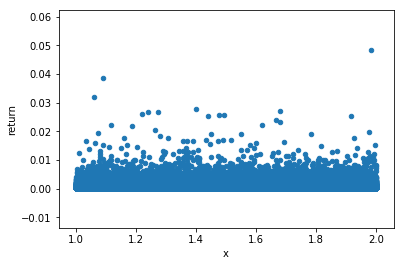

In [31]:
y_future[1].loc[y_future[1].target == 1].plot(x='x',y='return',kind='scatter')

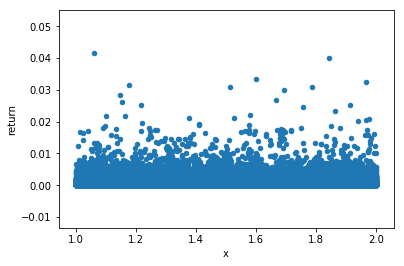

In [32]:
y_future[1].loc[y_future[1].target == -1].plot(x='x',y='return',kind='scatter')

In [33]:
print(y_future[1].loc[y_future[1].target == 1].describe())

         target         return              x
count  128767.0  128767.000000  128767.000000
mean        1.0       0.000656       1.498665
std         0.0       0.000953       0.288733
min         1.0       0.000038       1.000002
25%         1.0       0.000122       1.247883
50%         1.0       0.000387       1.498618
75%         1.0       0.000833       1.748093
max         1.0       0.048492       2.000000


In [34]:
print(y_future[1].loc[y_future[1].target == -1].describe())

         target         return              x
count  179392.0  179392.000000  179392.000000
mean       -1.0       0.000471       1.500291
std         0.0       0.000900       0.288472
min        -1.0       0.000000       1.000009
25%        -1.0       0.000000       1.250593
50%        -1.0       0.000183       1.500245
75%        -1.0       0.000613       1.749681
max        -1.0       0.041594       1.999990


In [35]:
from scipy import stats

In [36]:
print(stats.percentileofscore(y_future[1].loc[y_future[1].target == -1]['return'], 0.0015))
print((1 - 0.9313542410) * len(y_future[1].loc[y_future[1].target == -1]))

93.13542409917945
12314.499998528005


In [37]:
print(stats.percentileofscore(y_future[1].loc[y_future[1].target == 1]['return'], 0.0015))
print((1 - 0.8991900099) * len(y_future[1].loc[y_future[1].target == 1]))

89.91900098627754
12980.999995206703


In [38]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler

In [39]:
for column in df.columns:
    if column == 'target':
        df[column] = df[column].astype(np.int64)
    else:
        df[column] = df[column].astype(np.float64)
for column in y_future[1].columns:
    if column == 'target':
        y_future[1][column] = y_future[1][column].astype(np.int64)
    else:
        y_future[1][column] = y_future[1][column].astype(np.float64)

In [40]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import talib

In [41]:
ema = pd.DataFrame(talib.EMA(np.array(df.close), timeperiod=3))
tema = pd.DataFrame(talib.TEMA(np.array(df.close), timeperiod=3))
rsi = pd.DataFrame(talib.RSI(np.array(df.close), timeperiod=3))
rocrsi = pd.DataFrame(talib.ROC(talib.RSI(np.array(df.close), timeperiod=3), timeperiod=3))
rocema = pd.DataFrame(talib.ROC(talib.EMA(np.array(df.close), timeperiod=3), timeperiod=3))
roctema = pd.DataFrame(talib.ROC(talib.TEMA(np.array(df.close), timeperiod=3), timeperiod=3))
macd, two, three = talib.MACD(np.array(df.close), fastperiod=12, slowperiod=26)

In [42]:
df['ema'] = ema.shift(periods=1).values
df['tema'] = tema.shift(periods=1).values
df['rsi'] = rsi.shift(periods=1).values
df['rocrsi'] = rocrsi.shift(periods=1).values
df['rocema'] = rocema.shift(periods=1).values
df['roctema'] = roctema.shift(periods=1).values
df['macd'] = pd.DataFrame(macd).shift(periods=1).values

In [43]:
xTrain, xTest, yTrain, yTest = train_test_split(df.drop(y_future[1].index[y_future[1]['target'] == 0]), y_future[1].drop(y_future[1].index[y_future[1]['target'] == 0]), test_size=0.3)

scaler = StandardScaler()
xTrain = scaler.fit_transform(xTrain)
xTest = scaler.fit_transform(xTest)

In [44]:
clf = xgb.XGBClassifier()
clf.fit(xTrain, yTrain.target.values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [45]:
y_pred = clf.predict(xTest)
f1_score(yTest.target, y_pred)

0.24844

**Maybe we can try doing an iterative method where we retrain a model every x days to keep it as up do date as possible**

**But first, lets try an ARIMA model looking at the last 10 minutes to see how that performs**

In [46]:
df.head()

,avg_volume,buy_100,buy_1000,buy_10000,buy_100000,buy_200000,buy_50,buy_500,buy_count,buy_volume,...,sell_count,sell_volume,volume,ema,tema,rsi,rocrsi,rocema,roctema,macd
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-01 00:00:00,4061.297872,142.0,95.0,19.0,4.0,0.0,160.0,113.0,201.0,1490030.0,...,504.0,1373185.0,2863215.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-01 00:01:00,2111.574359,388.0,181.0,33.0,1.0,0.0,464.0,252.0,712.0,1479285.0,...,263.0,579500.0,2058785.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-01 00:02:00,3571.903039,347.0,186.0,22.0,0.0,0.0,382.0,232.0,571.0,1224395.0,...,120.0,1243790.0,2468185.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-01 00:03:00,2161.450116,87.0,49.0,3.0,0.0,0.0,108.0,65.0,172.0,263639.0,...,259.0,667946.0,931585.0,8555.5,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-01 00:04:00,2798.259649,28.0,15.0,3.0,0.0,0.0,32.0,23.0,48.0,170871.0,...,237.0,626633.0,797504.0,8559.0,NaN,87.755102,NaN,NaN,NaN,NaN


In [47]:
df.columns = [column + '_1' for column in df.columns]

In [48]:
base_columns = [word[:-2] for word in df.columns]

In [49]:
for i in range(2,12):
    for column in base_columns:
        df[column + '_' + str(i)] = np.nan

In [53]:
def asyncFunction(j): # we're now getting only the columns from j rather than the entire thing
    count = 0
    for i, row in df[10:].iterrows():
        if count % 10000 == 0:
            print('i: {} | j: {}'.format(i, j))
        for column in base_columns:
            df.at[i, column+'_'+str(j)] = df.loc[i-datetime.timedelta(minutes=j-1), column+'_1']
        count += 1
#     return dict({minutesAhead: pd.DataFrame(x.target)})

In [54]:
pickled_file_path = './pickled_files/arimaDataFrame.pickle'

if not os.path.exists(pickled_file_path):
    pool = mp.Pool(processes=mp.cpu_count())
    results = [pool.apply_async(asyncFunction, args=(j,)) for j in range(2,12)]
    optimized_returns = [p.get() for p in results]
    
    with open(pickled_file_path, 'wb') as handle:
        pickle.dump(df, handle)
else:
    df = pickle.load(open(pickled_file_path,'rb'))

i: 2019-06-01 00:10:00 | j: 3
i: 2019-06-01 00:10:00 | j: 4
i: 2019-06-01 00:10:00 | j: 5
i: 2019-06-01 00:10:00 | j: 2


Process ForkPoolWorker-9:
Process ForkPoolWorker-11:
Process ForkPoolWorker-12:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/ikigai-ml/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/anaconda3/envs/ikigai-ml/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/ikigai-ml/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/ikigai-ml/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/ikigai-ml/lib/python3.5/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/opt/anaconda3/envs/ikigai-ml/lib/python3.5/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-53-7ea4bbbead38>", line

i: 2019-06-01 00:10:00 | j: 6


KeyboardInterrupt
  File "/opt/anaconda3/envs/ikigai-ml/lib/python3.5/site-packages/pandas/core/frame.py", line 2030, in _set_value
    engine.set_value(series._values, index, value)
  File "/opt/anaconda3/envs/ikigai-ml/lib/python3.5/site-packages/pandas/core/series.py", line 403, in _values
    return self._data.internal_values()
  File "/opt/anaconda3/envs/ikigai-ml/lib/python3.5/site-packages/pandas/core/internals.py", line 4507, in internal_values
    return self._block.internal_values()
KeyboardInterrupt


KeyboardInterrupt: 

i: 2019-06-01 00:10:00 | j: 8
i: 2019-06-01 00:10:00 | j: 9
i: 2019-06-01 00:10:00 | j: 7
i: 2019-06-01 00:10:00 | j: 10
i: 2019-06-01 00:10:00 | j: 11
i: 2019-06-07 22:50:00 | j: 7
i: 2019-06-07 22:50:00 | j: 10
i: 2019-06-07 22:50:00 | j: 9
i: 2019-06-07 22:50:00 | j: 8
i: 2019-06-07 22:50:00 | j: 6
i: 2019-06-01 00:10:00 | j: 10
i: 2019-06-01 00:10:00 | j: 11
i: 2019-06-14 21:30:00 | j: 7
i: 2019-06-14 21:30:00 | j: 6
i: 2019-06-07 22:50:00 | j: 11
i: 2019-06-21 20:10:00 | j: 7
i: 2019-06-21 20:10:00 | j: 6


In [61]:
df.loc[df.index[0],[column+'_2' for column in base_columns]]

avg_volume_2    NaN
buy_100_2       NaN
buy_1000_2      NaN
buy_10000_2     NaN
buy_100000_2    NaN
buy_200000_2    NaN
buy_50_2        NaN
buy_500_2       NaN
buy_count_2     NaN
buy_volume_2    NaN
close_2         NaN
high_2          NaN
low_2           NaN
max_buy_2       NaN
max_sell_2      NaN
open_2          NaN
sell_100_2      NaN
sell_1000_2     NaN
sell_10000_2    NaN
sell_100000_2   NaN
sell_200000_2   NaN
sell_50_2       NaN
sell_500_2      NaN
sell_count_2    NaN
sell_volume_2   NaN
volume_2        NaN
ema_2           NaN
tema_2          NaN
rsi_2           NaN
rocrsi_2        NaN
rocema_2        NaN
roctema_2       NaN
macd_2          NaN
Name: 2019-06-01 00:00:00, dtype: float64

In [ ]:
d = xgb.DMatrix(data=df.drop(y_future[1].index[y_future[1]['target'] == 0]), label=y_future[1].drop(y_future[1].index[y_future[1]['target'] == 0]))
params = {
    'lambda': 1
    'max_depth': 4
}

clf = xgb.cv(params=params, data=d, nfold=10)

**Now lets try the rolling model and see how it performs, lets train the model on a monthly basis and retrain every month and see how well it performs**